In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [43]:
df = pd.read_csv("C:/PW/Semestr 4/ML/Projekt 1/data/proccessed_data.csv")

In [44]:
df.head(5)

,BEDS,BATH,SQFT_LOG,ZIPCODE,SUBLOCALITY,BROKERTITLE,TYPE,LATITUDE,LONGITUDE,PRICE_CATEGORY
0,3,1.0,3.339294,10021,New York,Corcoran West Side,Co-op for sale,40.767820,-73.959425,Cheap
1,2,2.0,2.956168,11374,Queens County,EXP Realty,Condo for sale,40.732471,-73.867080,Mid
2,3,2.0,3.229426,10305,Richmond County,Momentum Real Estate LLC,Multi-family home for sale,40.587072,-74.094436,Mid
3,2,1.0,3.339294,10025,New York,COMPASS,Co-op for sale,40.799157,-73.969032,Mid
4,3,1.0,2.698970,10034,New York,New Heights Realty,Co-op for sale,40.871796,-73.916064,Cheap


## Podział na zbiór treningowy i testowy

In [45]:
X = df.drop(["PRICE_CATEGORY"], axis=1)
y = df["PRICE_CATEGORY"]
columns = list(X.columns)

## Kodowanie i skalowanie danych

In [46]:
labels_dict = {"Cheap": 0, "Mid": 1, "Expensive": 2}
y = y.map(labels_dict)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

In [48]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

to_encode = ["SUBLOCALITY", "TYPE", "ZIPCODE", "BROKERTITLE"]
to_scale = ["BEDS",	"BATH",	"SQFT_LOG", "LATITUDE", "LONGITUDE"]

preprocessing = ColumnTransformer([
    ('target_encoder', TargetEncoder(), to_encode),
    ("scaler", StandardScaler(), to_scale)
])
preprocessing.fit(X_train, y_train)
X_train = preprocessing.transform(X_train)
X_test = preprocessing.transform(X_test)

## Modele

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

In [9]:
model1 = LogisticRegression(random_state=1)

max_iter= [100, 1000, 10000, 100000]

param_grid = dict(max_iter=max_iter)

grid = GridSearchCV(estimator=model1, param_grid=param_grid, cv=5, n_jobs=-1)

grid_results= grid.fit(X_train, y_train)  

print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))

Best: 0.800658 using {'max_iter': 100000}


In [10]:
model2 = DecisionTreeClassifier(random_state=1)

max_depth=[2, 3, 4, 5, 6]
criterion=["gini","entrophy"]
ccp_alpha=[0, 0.05]
max_features = ["sqrt", "log2"]
param_grid = dict(max_depth=max_depth,criterion=criterion, ccp_alpha=ccp_alpha, max_features=max_features)

grid = GridSearchCV(estimator=model2, param_grid=param_grid, cv=5, n_jobs=-1)

grid_results = grid.fit(X_train , y_train)
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))


Best: 0.806001 using {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt'}


In [11]:
model3 = SVC()

C = [1, 10, 100] # strength of the regularization
degree = [1, 2, 3, 4, 5, 6] # degree of the polynomial kernel function
gamma = ['scale', 'auto', 0.01, 0.1]

param_grid = dict(C=C, degree=degree, gamma=gamma)

grid = GridSearchCV(estimator=model3, param_grid=param_grid, cv=5, n_jobs=-1)

grid_results = grid.fit(X_train , y_train)
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))

Best: 0.824947 using {'C': 100, 'degree': 1, 'gamma': 0.01}


In [12]:
model4 = KNeighborsClassifier()

n_neighbors = [3, 4, 5, 6, 7, 8]
weights = ["uniform", "distance"]
metric = ["mirkowski", "euclidean", "cosine"]

param_grid = dict(n_neighbors=n_neighbors, weights=weights, metric=metric)

grid = GridSearchCV(estimator=model4, param_grid=param_grid, cv=5, n_jobs=-1)

grid_results = grid.fit(X_train , y_train)
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))

Best: 0.829078 using {'metric': 'cosine', 'n_neighbors': 7, 'weights': 'uniform'}


In [13]:
model5 = RandomForestClassifier()

n_estimators = [50, 100, 500, 1000]
criterion = ["gini", "entropy", "log_loss"] 
# gini - how often a randomly chosen element of a set would be incorrectly labeled
# entropy - degree of impurity, uncertainty, or surprise
max_depth = [2, 4, 5, 6, 8]
max_features = ["sqrt", "log2"]

param_dist = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, max_features=max_features)


random = RandomizedSearchCV(estimator=model5, param_distributions=param_dist , cv=5, n_jobs=-1)

random_result = random.fit(X_train, y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.848843 using {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}


In [14]:
model6 = GradientBoostingClassifier(random_state=1)

loss = ["log_loss", "exponential"]
criterion = ["friedman_mse", "squared_error"]
n_estimators = [50, 100, 500, 1000]
learning_rate = [0.1, 0.01, 0.05]
max_depth = [2, 4, 5, 6, 8]
max_features = ["sqrt", "log2"]


param_dist = dict(loss= loss, 
                  criterion=criterion, 
                  n_estimators= n_estimators,
                  learning_rate= learning_rate,
                  max_depth=max_depth, 
                  max_features=max_features)


random = RandomizedSearchCV(estimator=model6, 
                            param_distributions=param_dist , 
                            cv=5, 
                            n_jobs=-1)

random_result = random.fit(X_train, y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.854611 using {'n_estimators': 1000, 'max_features': 'log2', 'max_depth': 4, 'loss': 'log_loss', 'learning_rate': 0.1, 'criterion': 'squared_error'}


## AutoML

In [15]:
from tpot import TPOTClassifier
from scipy.sparse import csr_matrix

In [16]:
X_train_sparse = csr_matrix(X_train)

In [17]:
tpot = TPOTClassifier(generations=3,
                      verbosity=2, 
                      config_dict='TPOT sparse')
tpot.fit(X_train_sparse, y_train)

                                                                              
Generation 1 - Current best internal CV score: 0.8583165754528871
                                                                              
Generation 2 - Current best internal CV score: 0.8583165754528871
                                                                              
Generation 3 - Current best internal CV score: 0.8616053625217427
                                                                              
Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.2, min_samples_leaf=1, min_samples_split=2, n_estimators=100)


TPOTClassifier(config_dict='TPOT sparse', generations=3, verbosity=2)

In [18]:
tpot.score(X_test, y_test)

0.8601973684210527

## Max Voting


In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

In [22]:
def eval_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    score = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

    return score

In [20]:
model1= SVC(C=100, degree=1, gamma=0.01)
model2= DecisionTreeClassifier(random_state=1, 
                                ccp_alpha=0, 
                                criterion= 'gini', 
                                max_depth= 6, 
                                max_features="sqrt")

model3= KNeighborsClassifier(n_neighbors=7, 
                             weights="distance", 
                             metric="cosine")

model4= LogisticRegression(max_iter=100000, random_state=1)

model5= GradientBoostingClassifier(random_state=1,
                                    n_estimators=1000,
                                    criterion="squared_error",
                                    learning_rate=0.1,
                                    loss="log_loss",
                                    max_depth=4,
                                    max_features="log2")

model6= XGBClassifier(learning_rate=0.5, 
                      max_depth=4, 
                      min_child_weight=3, 
                      n_estimators=100, 
                      n_jobs=1, 
                      subsample=0.9500000000000001, 
                      verbosity=0)

model7= RandomForestClassifier(bootstrap=True, 
                               criterion="entropy", 
                               max_features=0.2, 
                               min_samples_leaf=1, 
                               min_samples_split=2, 
                               n_estimators=100)


estimators= [("SVC", model1), ("DT", model2), ("KN", model3), ("LR", model4), ("GBC", model5), ("XGB", model6), ("RFC", model7)]

In [23]:
for estimator, model in estimators:
    score= eval_model(model, X_train, y_train)
    print(f"{estimator}:")
    print(f"mean: {score.mean()}, std: {score.std()}")
    
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predicted)
    display(accuracy)
    class_report = classification_report(y_test, y_predicted)
    print(class_report)

SVC:
mean: 0.8259225319248228, std: 0.01460330233609058


0.8174342105263158

              precision    recall  f1-score   support

           0       0.86      0.66      0.74       146
           1       0.80      0.92      0.86       360
           2       0.84      0.68      0.75       102

    accuracy                           0.82       608
   macro avg       0.83      0.75      0.78       608
weighted avg       0.82      0.82      0.81       608

DT:
mean: 0.8033985264378545, std: 0.017264946277957126


0.8075657894736842

              precision    recall  f1-score   support

           0       0.90      0.57      0.70       146
           1       0.78      0.94      0.85       360
           2       0.83      0.69      0.75       102

    accuracy                           0.81       608
   macro avg       0.84      0.73      0.77       608
weighted avg       0.82      0.81      0.80       608

KN:
mean: 0.8301715384724169, std: 0.014487701591916818


0.8141447368421053

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       146
           1       0.82      0.88      0.85       360
           2       0.82      0.70      0.75       102

    accuracy                           0.81       608
   macro avg       0.81      0.77      0.79       608
weighted avg       0.81      0.81      0.81       608

LR:
mean: 0.8025845318399728, std: 0.018014891810559725


0.787828947368421

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       146
           1       0.77      0.91      0.83       360
           2       0.82      0.55      0.66       102

    accuracy                           0.79       608
   macro avg       0.80      0.71      0.74       608
weighted avg       0.79      0.79      0.78       608

GBC:
mean: 0.8515984331028241, std: 0.014668936184451215


0.8651315789473685

              precision    recall  f1-score   support

           0       0.89      0.77      0.83       146
           1       0.86      0.93      0.89       360
           2       0.84      0.77      0.81       102

    accuracy                           0.87       608
   macro avg       0.86      0.83      0.84       608
weighted avg       0.87      0.87      0.86       608

XGB:
mean: 0.8525555414138845, std: 0.013367835001853649


0.8585526315789473

              precision    recall  f1-score   support

           0       0.90      0.76      0.82       146
           1       0.84      0.94      0.89       360
           2       0.87      0.72      0.78       102

    accuracy                           0.86       608
   macro avg       0.87      0.80      0.83       608
weighted avg       0.86      0.86      0.86       608

RFC:
mean: 0.8551643969284292, std: 0.012772339321316847


0.8552631578947368

              precision    recall  f1-score   support

           0       0.92      0.75      0.83       146
           1       0.83      0.95      0.89       360
           2       0.87      0.68      0.76       102

    accuracy                           0.86       608
   macro avg       0.87      0.79      0.83       608
weighted avg       0.86      0.86      0.85       608



In [40]:
model_hard= VotingClassifier(estimators=estimators, voting='hard')
score = eval_model(model_hard, X_train, y_train)
print("VotingClassifier:")
print(f"mean: {score.mean()}, std: {score.std()}")

model_hard.fit(X_train, y_train)
y_predicted = model_hard.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
display(accuracy)
class_report = classification_report(y_test, y_predicted)
print(class_report)

VotingClassifier:
mean: 0.7784181126525535, std: 0.014736703549726284
              precision    recall  f1-score   support

           0       0.86      0.71      0.77       146
           1       0.77      0.91      0.83       360
           2       0.74      0.45      0.56       102

    accuracy                           0.78       608
   macro avg       0.79      0.69      0.72       608
weighted avg       0.79      0.78      0.77       608



## Stacking

In [41]:
from sklearn.ensemble import StackingClassifier

In [ ]:
stc= StackingClassifier(estimators=estimators, final_estimator= LogisticRegression())
score= eval_model(stc, X_train, y_train)
print("StackingClassifier:")
print(f"mean: {score.mean()}, std: {score.std()}")

stc.fit(X_train, y_train)
y_predicted = stc.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
display(accuracy)
class_report = classification_report(y_test, y_predicted)
print(class_report)

## Explainable AI

In [29]:
import shap
import matplotlib.pyplot as plt

In [71]:
model7.fit(X_train, y_train)

y_pred = model7.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
display(accuracy)
print(classification_report(y_pred, y_test))

0.8552631578947368

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       124
           1       0.95      0.84      0.89       409
           2       0.66      0.89      0.76        75

    accuracy                           0.86       608
   macro avg       0.79      0.88      0.83       608
weighted avg       0.88      0.86      0.86       608



In [72]:
explainer = shap.TreeExplainer(model7)

In [73]:
X_test_df = pd.DataFrame(X_test, columns= list(preprocessing.feature_names_in_))

In [74]:
shap_values = explainer.shap_values(X_test_df)

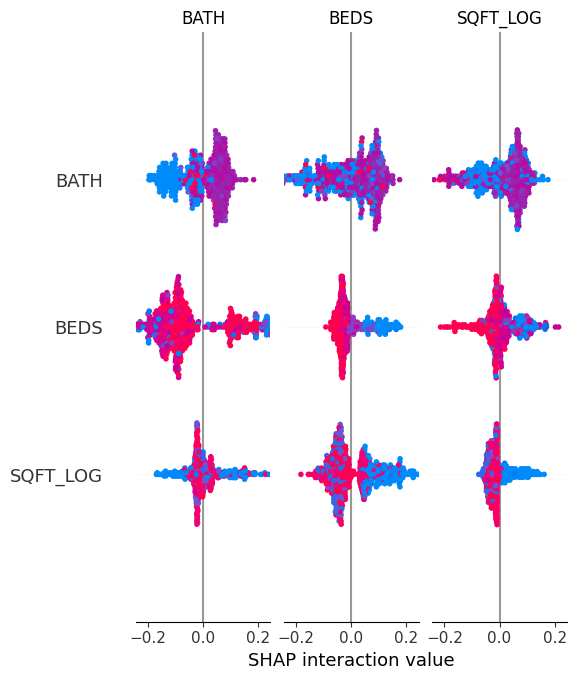

In [75]:
shap.summary_plot(shap_values, X_test_df)

In [77]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_df.iloc[0])

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

In [ ]:
from lime.lime_tabular import LimeTabularExplainer